# Projet MTH2329 : Génération de données par modèles génératifs

**Auteur** : [Votre Nom]
**Date** : Janvier 2026

Ce notebook présente la réalisation du projet de génération de courbes gaussiennes. Il compare deux approches :
1.  **ACP + GMM** (Approche classique)
2.  **Autoencodeur + GMM** (Deep Learning)

## Importation des modules

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

# Importation des modules du projet
from data_generation import create_gaussian_curves
import pca_gmm_pipeline as pca_pipeline
import autoencoder_gmm_pipeline as ae_pipeline
import evaluation
import utils

%matplotlib inline
np.random.seed(42)

# Partie 1 : Approche ACP + GMM

Dans cette partie, nous utilisons l'Analyse en Composantes Principales (ACP) pour réduire la dimension des courbes, puis nous modélisons la distribution dans l'espace réduit avec un mélange de gaussiennes (GMM).

## 1.1 Génération des données
Nous générons $N=3000$ courbes gaussiennes discrétisées sur 400 points.

In [143]:
N = 3000
nbx = 400
xmin, xmax = -6, 6
sd_noise = 0.0

# Génération des paramètres aléatoires
mu = np.random.normal(loc=0., scale=1., size=N)
sd = np.random.gamma(shape=7.0, scale=0.2, size=N)

# Création des courbes
x, Y = create_gaussian_curves(mu, sd, N, xmin, xmax, nbx, sd_noise=sd_noise)

print(f"Dimensions des données : {Y.shape}")

Dimensions des données : (3000, 400)


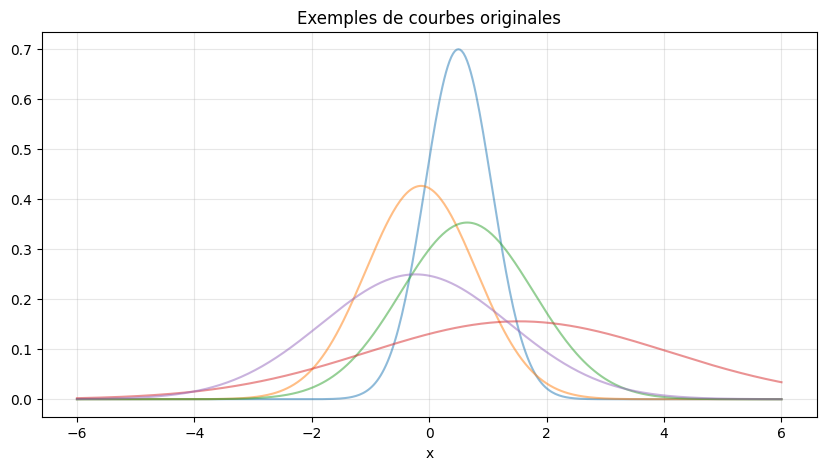

In [144]:
# Visualisation de quelques courbes originales
utils.plot_generated_curves(x, Y, title="Exemples de courbes originales", num_samples=5)

## 1.2 Réduction de dimension (ACP)
Nous réduisons la dimension de 400 à 20 composantes principales.

In [145]:
n_components_pca = 20

print(f"Entraînement ACP ({n_components_pca} composantes)...")
Z_pca, mse, var_ratio, pca_model, scaler_pca = pca_pipeline.analyze_pca(Y, n_components_pca)

Entraînement ACP (20 composantes)...


Variance expliquée cumulée : 1.0000


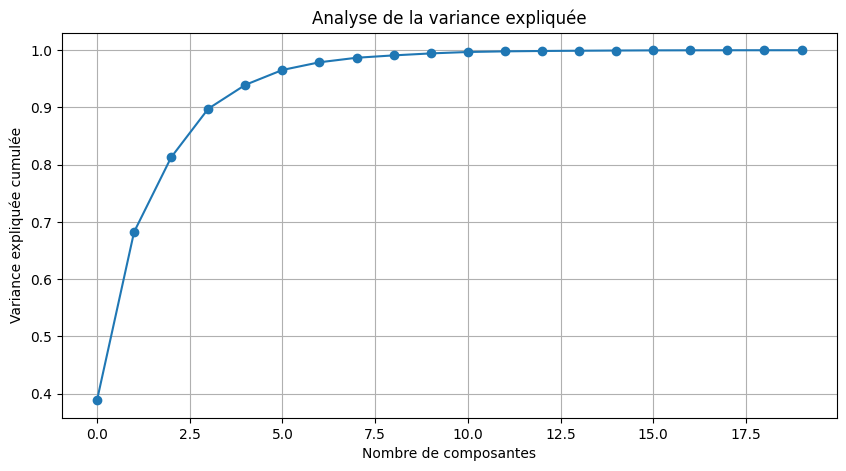

In [146]:
# Visualisation de la variance expliquée
print(f"Variance expliquée cumulée : {np.sum(var_ratio):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(var_ratio), marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Analyse de la variance expliquée")
plt.grid(True)
plt.show()

## 1.3 Modélisation par GMM
Nous entraînons un modèle de mélange gaussien (GMM) sur l'espace latent réduit (taille 20).

In [147]:
n_components_gmm = 8 # Nombre de clusters

print(f"Entraînement GMM ({n_components_gmm} clusters)...")
gmm_pca = pca_pipeline.fit_gmm(Z_pca, n_components=n_components_gmm, random_state=42)

print(f"Converged: {gmm_pca.converged_}")

Entraînement GMM (8 clusters)...
Converged: True


## 1.4 Échantillonnage et Reconstruction
Nous échantillonnons de nouveaux points dans l'espace latent via le GMM, puis nous les reconstruisons dans l'espace original (Inverse PCA).

In [148]:
print("Génération de nouvelles courbes...")
n_gen = 1000
Y_gen_pca, Z_gen_pca = pca_pipeline.generate_new_curves_gmm(gmm_pca, pca_model, scaler_pca, n_samples=n_gen)

print(f"Dimensions générées : {Y_gen_pca.shape}")

Génération de nouvelles courbes...
Dimensions générées : (1000, 400)


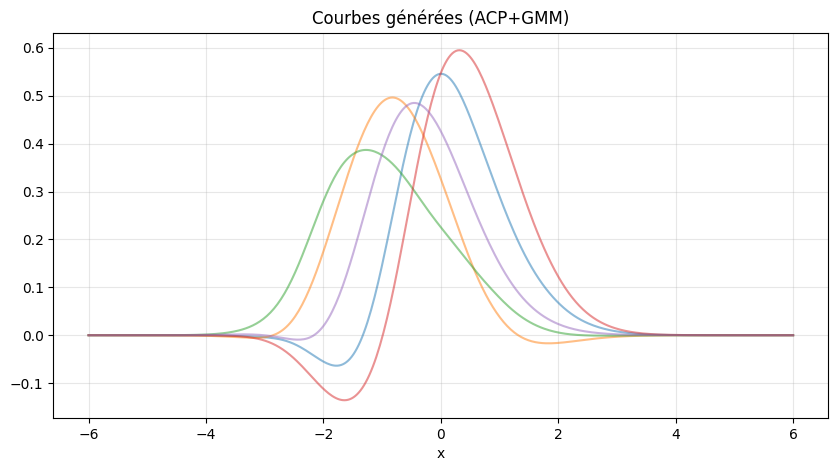

In [149]:
# Visualisation des courbes générées
utils.plot_generated_curves(x, Y_gen_pca, title="Courbes générées (ACP+GMM)", num_samples=5)

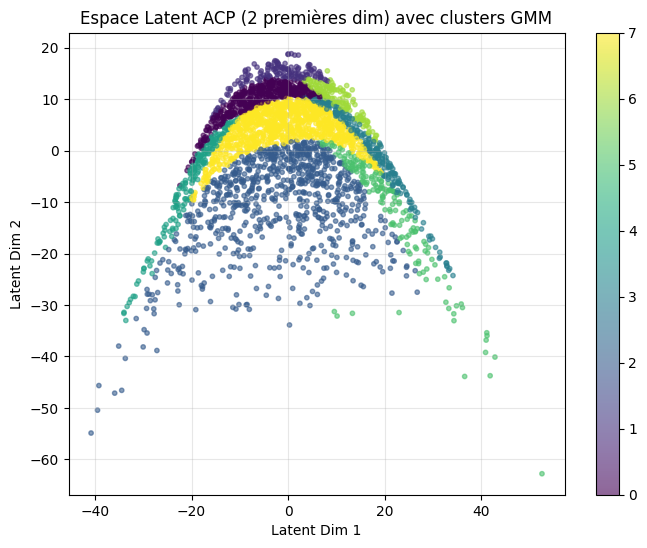

In [150]:
# Visualisation de l'espace latent et des clusters
labels_pca = gmm_pca.predict(Z_pca)
utils.plot_latent_space(Z_pca, labels_pca, title="Espace Latent ACP (2 premières dim) avec clusters GMM")

# Partie 2 : Approche Autoencodeur + GMM

Nous remplaçons ici l'ACP classique par un Autoencodeur pour apprendre une représentation latente non-linéaire.

## 2.1 Configuration et Entraînement de l'Autoencodeur
Nous définissons une architecture Encodeur-Décodeur et l'entraînons sur les données normalisées.

In [151]:
# Configuration
input_dim = nbx
latent_dim = 10       
hidden_dims = [128, 64]
epochs = 50
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Entraînement sur : {device}")

Entraînement sur : cpu


In [152]:
# Normalisation des données pour l'AE
from sklearn.preprocessing import StandardScaler
scaler_ae = StandardScaler()
Y_scaled = scaler_ae.fit_transform(Y) # Important de normaliser pour les réseaux de neurones

In [153]:
# Instanciation du modèle
ae_model = ae_pipeline.Autoencoder(input_dim, latent_dim, hidden_dims)
print(ae_model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=400, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=400, bias=True)
  )
)


In [154]:
# Boucle d'entraînement
print("Démarrage de l'entraînement...")
losses = ae_pipeline.train_autoencoder(ae_model, Y_scaled, epochs=epochs, batch_size=batch_size, device=device)

Démarrage de l'entraînement...
Epoch [10/50], Loss: 0.014144
Epoch [20/50], Loss: 0.005594
Epoch [30/50], Loss: 0.003468
Epoch [40/50], Loss: 0.003487
Epoch [50/50], Loss: 0.001699


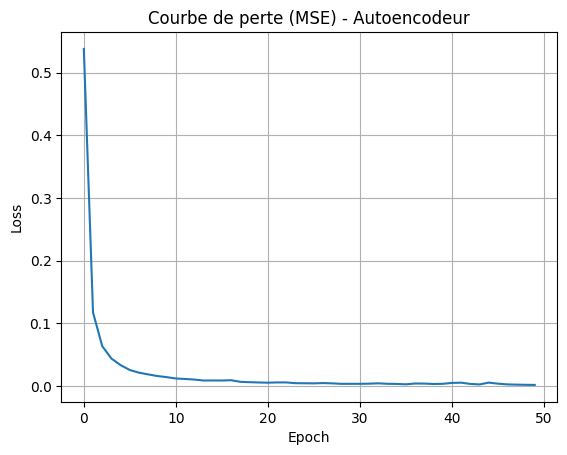

In [155]:
# Courbe d'apprentissage
plt.figure()
plt.plot(losses)
plt.title("Courbe de perte (MSE) - Autoencodeur")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## 2.2 Projection dans l'espace latent et modélisation GMM
Nous projetons toutes les courbes dans l'espace latent de dimension 10 et apprenons un GMM dessus.

In [156]:
print("Projection des données...")
Z_ae = ae_pipeline.get_latent_space(ae_model, Y_scaled, device=device)

print(f"Forme de l'espace latent : {Z_ae.shape}")

Projection des données...
Forme de l'espace latent : (3000, 10)


In [157]:
print(f"Entraînement GMM sur latent AE ({n_components_gmm} clusters)...")
gmm_ae = ae_pipeline.fit_gmm_on_latent(Z_ae, n_components=n_components_gmm, random_state=42)

print(f"Converged: {gmm_ae.converged_}")

Entraînement GMM sur latent AE (8 clusters)...
Converged: True


## 2.3 Échantillonnage et Reconstruction
Nous générons de nouvelles courbes en échantillonnant le GMM latent puis en décodant via le réseau de neurones.

In [158]:
print("Génération de nouvelles courbes via AE...")
Y_gen_ae, Z_gen_ae = ae_pipeline.generate_new_curves_ae(gmm_ae, ae_model, scaler_ae, n_samples=n_gen, device=device)

print(f"Dimensions générées : {Y_gen_ae.shape}")

Génération de nouvelles courbes via AE...
Dimensions générées : (1000, 400)


/home/raph/.pyenv/versions/3.10.19/lib/python3.10/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


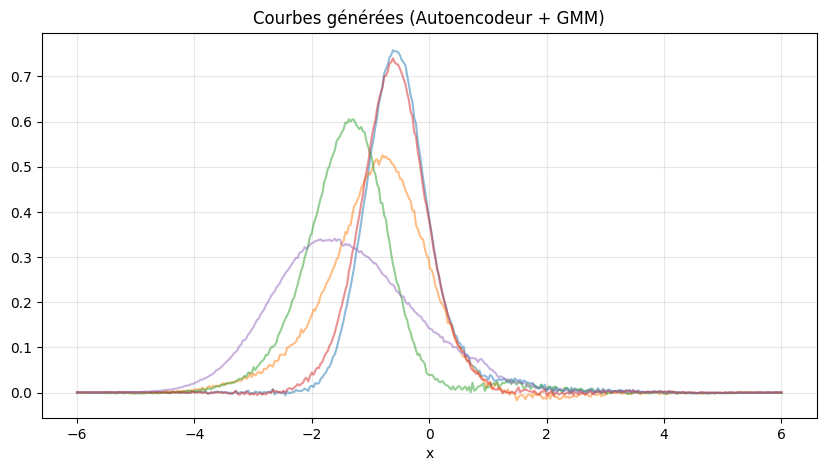

In [159]:
# Visualisation des courbes générées (AE)
utils.plot_generated_curves(x, Y_gen_ae, title="Courbes générées (Autoencodeur + GMM)", num_samples=5)

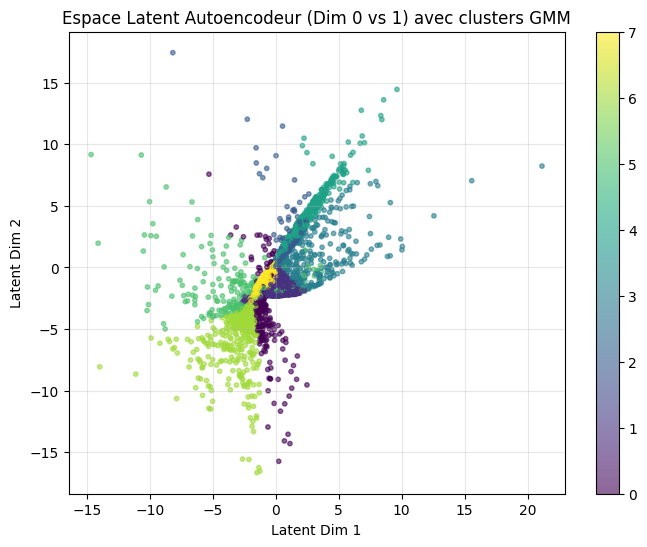

In [160]:
# Visualisation de l'espace latent
labels_ae = gmm_ae.predict(Z_ae)
# Note: Z_ae est de dimension 10, le plot n'affiche que les 2 premières dimensions
utils.plot_latent_space(Z_ae, labels_ae, title="Espace Latent Autoencodeur (Dim 0 vs 1) avec clusters GMM")

# Partie 3 : Comparaison et Analyse

## 3.1 Comparaison Quantitative

In [161]:
# Création d'un jeu de test
N_test = 500
mu_test = np.random.normal(0., 1., size=N_test)
sd_test = np.random.gamma(7.0, 0.2, size=N_test)
_, Y_test = create_gaussian_curves(mu_test, sd_test, N_test, xmin, xmax, nbx, 0.0)

In [162]:
# 1. Erreur de Reconstruction (MSE) sur Test

# ACP (Project then Reconstruct)
Z_test_pca = pca_model.transform(scaler_pca.transform(Y_test))
Y_test_rec_pca = pca_pipeline.reconstruct_curves(Z_test_pca, n_components_pca, pca_model, scaler_pca)
mse_pca = evaluation.compute_mse(Y_test, Y_test_rec_pca)

# AE (Normalize then Forward)
Y_test_scaled = scaler_ae.transform(Y_test)
with torch.no_grad():
    ae_model.eval()
    Y_test_rec_ae_scaled_t, _ = ae_model(torch.FloatTensor(Y_test_scaled).to(device))
    Y_test_rec_ae = scaler_ae.inverse_transform(Y_test_rec_ae_scaled_t.cpu().numpy())
mse_ae = evaluation.compute_mse(Y_test, Y_test_rec_ae)

print(f"MSE Reconstruction ACP (d={n_components_pca}): {mse_pca:.6f}")
print(f"MSE Reconstruction AE  (d={latent_dim}): {mse_ae:.6f}")

MSE Reconstruction ACP (d=20): 0.000000
MSE Reconstruction AE  (d=10): 0.000059


In [163]:
# 2. Qualité des Générations
stats_pca, _ = evaluation.evaluate_generation_quality((mu, sd), Y_gen_pca, x)
stats_ae, _ = evaluation.evaluate_generation_quality((mu, sd), Y_gen_ae, x)
print("Stats ACP:", stats_pca)
print("Stats AE :", stats_ae)

Stats ACP: {'mu_mean_gen': 0.03796856943009142, 'mu_std_gen': 0.968870350704691, 'sigma_mean_gen': nan, 'sigma_std_gen': nan, 'mu_mean_orig': 0.03200083587583517, 'mu_std_orig': 0.9866431013460328, 'sigma_mean_orig': 1.3997637533441463, 'sigma_std_orig': 0.534105196997456, 'diff_mu_mean': 0.005967733554256255, 'diff_sigma_mean': nan}
Stats AE : {'mu_mean_gen': 0.04202007168421941, 'mu_std_gen': 0.9662733823097401, 'sigma_mean_gen': nan, 'sigma_std_gen': nan, 'mu_mean_orig': 0.03200083587583517, 'mu_std_orig': 0.9866431013460328, 'sigma_mean_orig': 1.3997637533441463, 'sigma_std_orig': 0.534105196997456, 'diff_mu_mean': 0.010019235808384243, 'diff_sigma_mean': nan}


/home/raph/Projects/MTH2329-data-generation/evaluation.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_est = np.sqrt(var_est)


/home/raph/Projects/MTH2329-data-generation/evaluation.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_est = np.sqrt(var_est)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

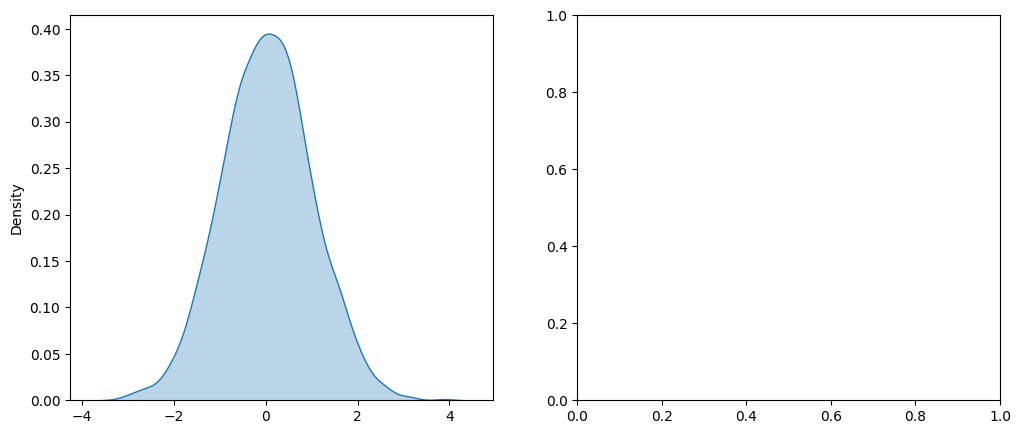

In [170]:
# Visualisation des distributions de paramètres (Original vs Généré)
# Recalcul des params pour le plot
_, (mu_gen_pca, sigma_gen_pca) = evaluation.evaluate_generation_quality(None, Y_gen_pca, x)
_, (mu_gen_ae, sigma_gen_ae) = evaluation.evaluate_generation_quality(None, Y_gen_ae, x)

# FIX: Ensure arrays are converted to numpy arrays and flat (1D) for seaborn using asarray + flatten
mu = np.asarray(mu).flatten()
sd = np.asarray(sd).flatten()
mu_gen_pca = np.asarray(mu_gen_pca).flatten()
sigma_gen_pca = np.asarray(sigma_gen_pca).flatten()
mu_gen_ae = np.asarray(mu_gen_ae).flatten()
sigma_gen_ae = np.asarray(sigma_gen_ae).flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution des moyennes (Mu)
sns.kdeplot(mu, ax=axes[0], label='Original', fill=True, alpha=0.3)
sns.kdeplot(mu_gen_pca, ax=axes[0], label='ACP+GMM', linestyle='--')
sns.kdeplot(mu_gen_ae, ax=axes[0], label='AE+GMM', linestyle='-.')
axes[0].set_title(r'Distribution des Moyennes ($\mu$)')
axes[0].legend()

# Distribution des écarts-types (Sigma)
sns.kdeplot(sd, ax=axes[1], label='Original', fill=True, alpha=0.3)
sns.kdeplot(sigma_gen_pca, ax=axes[1], label='ACP+GMM', linestyle='--')
sns.kdeplot(sigma_gen_ae, ax=axes[1], label='AE+GMM', linestyle='-.')
axes[1].set_title(r'Distribution des Écarts-types ($\sigma$)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.2 Comparaison Qualitative

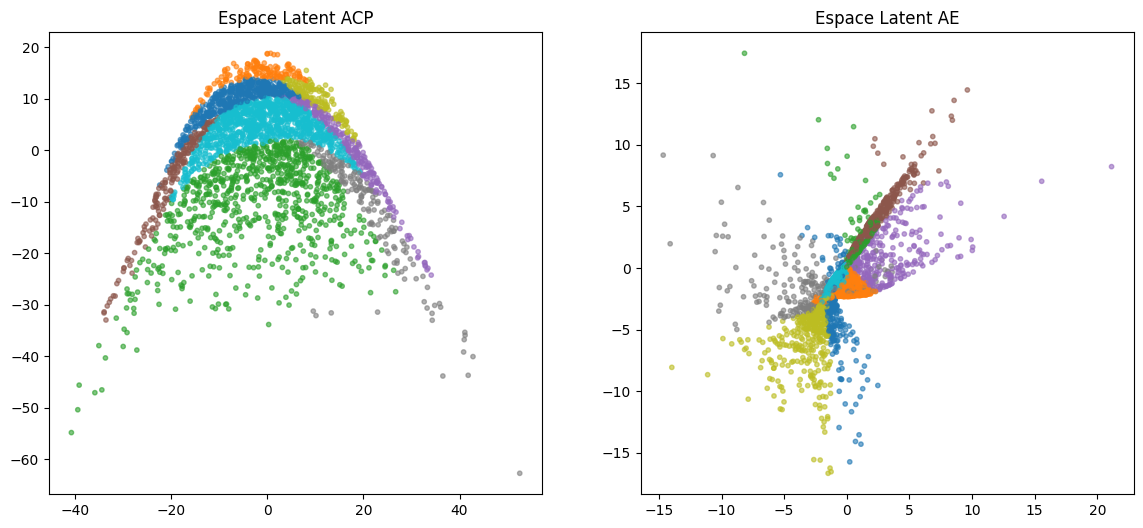

In [171]:
# Espace Latent
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=labels_pca, cmap='tab10', s=10, alpha=0.6)
axes[0].set_title('Espace Latent ACP')
axes[1].scatter(Z_ae[:, 0], Z_ae[:, 1], c=labels_ae, cmap='tab10', s=10, alpha=0.6)
axes[1].set_title('Espace Latent AE')
plt.show()

In [180]:
# Courbes par cluster
utils.plot_curves_from_clusters(x, Y_gen_ae, gmm_ae.predict(Z_gen_ae), n_clusters_show=3)

AttributeError: module 'utils' has no attribute 'plot_curves_from_clusters'

## 3.3 Expériences Complémentaires

Nous analysons ici la sensibilité des modèles à différents hyperparamètres.

### 1. Sensibilité à la dimension latente $d$
Nous entraînons l'ACP et l'Autoencodeur pour $d \in \{2, 5, 10, 20\}$ et comparons le MSE de reconstruction.

Analyse de sensibilité à d...
  Training AE d=2... Epoch [10/20], Loss: 0.032518
Epoch [20/20], Loss: 0.018736
MSE=0.00012
  Training AE d=5... Epoch [10/20], Loss: 0.013663
Epoch [20/20], Loss: 0.005776
MSE=0.00004
  Training AE d=10... Epoch [10/20], Loss: 0.012430
Epoch [20/20], Loss: 0.005524
MSE=0.00003
  Training AE d=20... Epoch [10/20], Loss: 0.011343
Epoch [20/20], Loss: 0.004765
MSE=0.00003


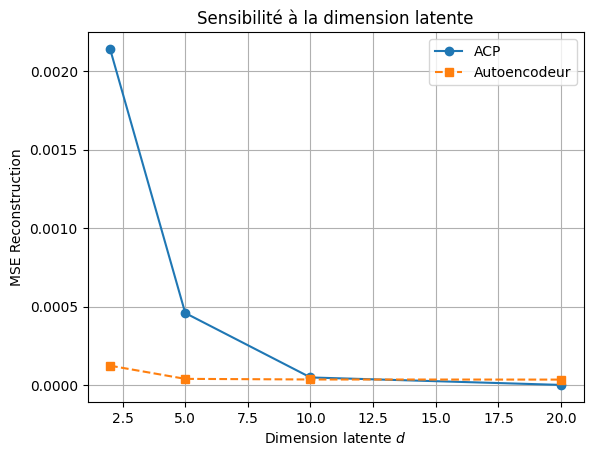

In [175]:
dims = [2, 5, 10, 20]
mse_results_pca = []
mse_results_ae = []

Y_scaled = scaler_ae.transform(Y) # Ensure scaled data is ready

print("Analyse de sensibilité à d...")
for d in dims:
    # ACP
    _, mse_pca_d, _, _, _ = pca_pipeline.analyze_pca(Y, d)
    mse_results_pca.append(mse_pca_d[-1])
    
    # AE
    print(f"  Training AE d={d}...", end=' ')
    temp_ae = ae_pipeline.Autoencoder(nbx, d, hidden_dims=[128, 64])
    # FIX: removed verbose=False
    ae_pipeline.train_autoencoder(temp_ae, Y_scaled, epochs=20, batch_size=64, device=device)
    
    # Eval
    temp_ae.eval()
    with torch.no_grad():
        Y_rec_sc, _ = temp_ae(torch.FloatTensor(Y_scaled).to(device))
        Y_rec = scaler_ae.inverse_transform(Y_rec_sc.cpu().numpy())
    mse_results_ae.append(evaluation.compute_mse(Y, Y_rec))
    print(f"MSE={mse_results_ae[-1]:.5f}")

plt.figure()
plt.plot(dims, mse_results_pca, 'o-', label='ACP')
plt.plot(dims, mse_results_ae, 's--', label='Autoencodeur')
plt.xlabel('Dimension latente $d$')
plt.ylabel('MSE Reconstruction')
plt.title('Sensibilité à la dimension latente')
plt.legend()
plt.grid(True)
plt.show()

### 2. Sensibilité au nombre de clusters GMM
Nous testons différentes valeurs de $K$ pour voir comment le GMM s'adapte à l'espace latent (exemple sur latent AE).

Analyse sensibilité K (GMM sur AE latent)...


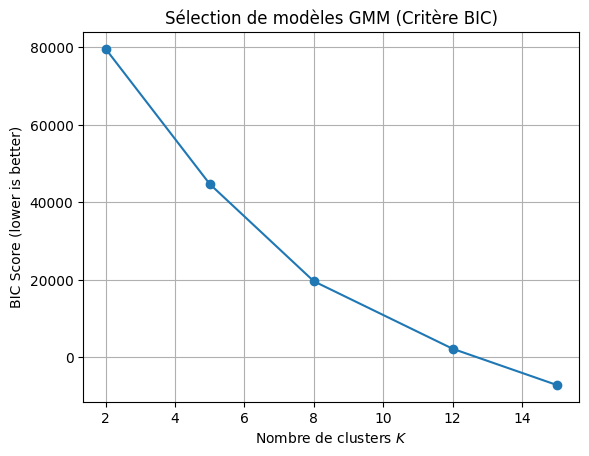

In [176]:
ks = [2, 5, 8, 12, 15]
bics = []

print("Analyse sensibilité K (GMM sur AE latent)...")
for k in ks:
    gmm_temp = pca_pipeline.fit_gmm(Z_ae, n_components=k, random_state=42)
    bics.append(gmm_temp.bic(Z_ae))

plt.figure()
plt.plot(ks, bics, 'o-')
plt.xlabel('Nombre de clusters $K$')
plt.ylabel('BIC Score (lower is better)')
plt.title('Sélection de modèles GMM (Critère BIC)')
plt.grid(True)
plt.show()

### 3. Robustesse au bruit
Nous ajoutons du bruit aux données d'entraînement et observons la dégradation.

Données bruitées générées.


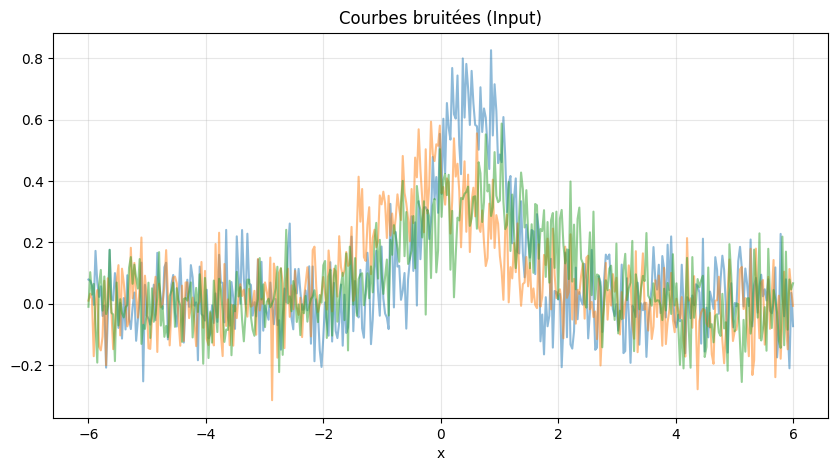

Epoch [10/20], Loss: 0.702967
Epoch [20/20], Loss: 0.685757


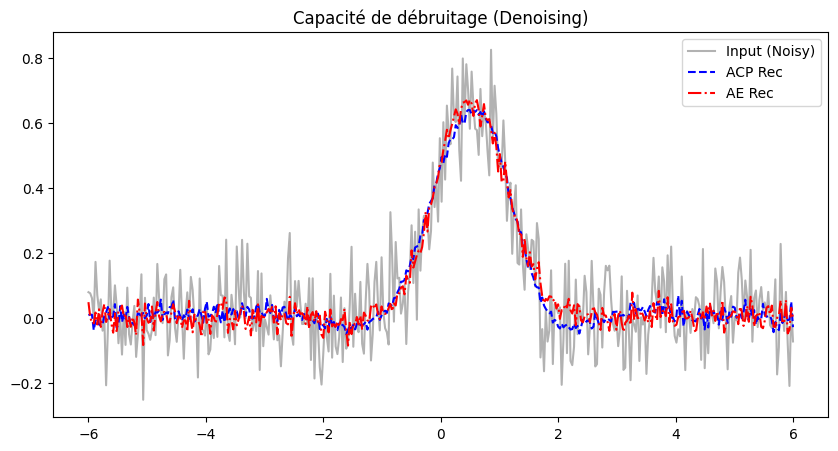

In [177]:
# Génération Données Bruitées
_, Y_noisy = create_gaussian_curves(mu, sd, N, xmin, xmax, nbx, sd_noise=0.1) # 10% Noise
print("Données bruitées générées.")
utils.plot_generated_curves(x, Y_noisy, title="Courbes bruitées (Input)", num_samples=3)

# Test rapide ACP vs AE sur données bruitées
# ACP
d_test = 10
Z_n, _, _, pca_n, scaler_n = pca_pipeline.analyze_pca(Y_noisy, d_test)
Y_rec_pca_n = pca_pipeline.reconstruct_curves(Z_n, d_test, pca_n, scaler_n)

# AE
Y_n_scaled = scaler_ae.fit_transform(Y_noisy)
ae_n = ae_pipeline.Autoencoder(nbx, d_test, hidden_dims=[128, 64])
# FIX: removed verbose=False
ae_pipeline.train_autoencoder(ae_n, Y_n_scaled, epochs=20, batch_size=64, device=device)
ae_n.eval()
with torch.no_grad():
    Y_rec_ae_n_sc, _ = ae_n(torch.FloatTensor(Y_n_scaled).to(device))
    Y_rec_ae_n = scaler_ae.inverse_transform(Y_rec_ae_n_sc.cpu().numpy())
    
# Comparaison visuelle Denoising
idx = 0
plt.figure(figsize=(10, 5))
plt.plot(x, Y_noisy[idx], 'k', alpha=0.3, label='Input (Noisy)')
plt.plot(x, Y_rec_pca_n[idx], 'b--', label='ACP Rec')
plt.plot(x, Y_rec_ae_n[idx], 'r-.', label='AE Rec')
plt.legend()
plt.title("Capacité de débruitage (Denoising)")
plt.show()

### 4. Interprétabilité
ACP : Les composantes principales sont des courbes (vecteurs propres).
AE : Exploration de l'espace latent (Latent Traversal).

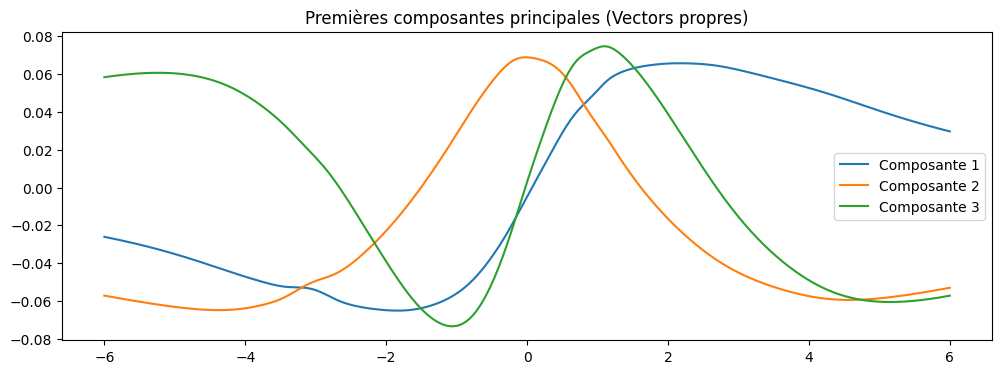

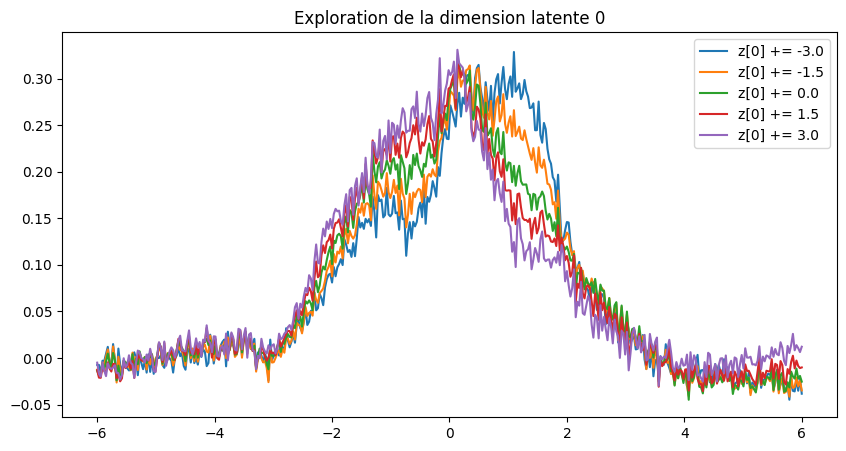

In [178]:
# 1. Composantes ACP
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(x, pca_model.components_[i], label=f'Composante {i+1}')
plt.title("Premières composantes principales (Vectors propres)")
plt.legend()
plt.show()

# 2. Traversée Latente AE (Latent Traversal)
# On part d'un vecteur latent moyen et on fait varier une seule dimension
z_mean = np.mean(Z_ae, axis=0)
dim_to_vary = 0
variations = np.linspace(-3, 3, 5) # Ecart types

plt.figure(figsize=(10, 5))
for v in variations:
    z_temp = z_mean.copy()
    z_temp[dim_to_vary] += v
    
    # Decode
    with torch.no_grad():
        z_t = torch.FloatTensor([z_temp]).to(device)
        rec_sc = ae_model.decode(z_t).cpu().numpy()
        rec = scaler_ae.inverse_transform(rec_sc)[0]
        
    plt.plot(x, rec, label=f'z[{dim_to_vary}] += {v:.1f}')
    
plt.title(f"Exploration de la dimension latente {dim_to_vary}")
plt.legend()
plt.show()

# Partie 4 : Rapport Synthétique

(Insérer ici vos réponses aux questions de réflexion basées sur les résultats ci-dessus)
